In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import shap
import missingno as msno

C:\Users\nyoja\AppData\Local\Temp\ipykernel_17912\1525809391.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\nyoja\anaconda3\envs\gpu2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('D:\projects\Afame_CustomerChurn\Churn_Modelling.csv')

In [3]:
print(df.head())
print(df.info())
print(df.describe())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [4]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

if missing_values.sum() == 0:
    print("There are no missing values in the dataset.")
else:
    print("There are missing values in the dataset.")
    msno.matrix(df)
    plt.show()

Missing values in each column:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
There are no missing values in the dataset.


In [5]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [6]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

Exploratory Data Analysis (EDA)

In [7]:
churn_rate = df['Exited'].mean()
print(f"Churn Rate: {churn_rate:.2%}")

Churn Rate: 20.37%


Churn Rate: 20.37%


C:\Users\nyoja\AppData\Local\Temp\ipykernel_17912\2400793547.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Exited', data=df, palette='pastel', width=0.3)  # Reduced width for bars


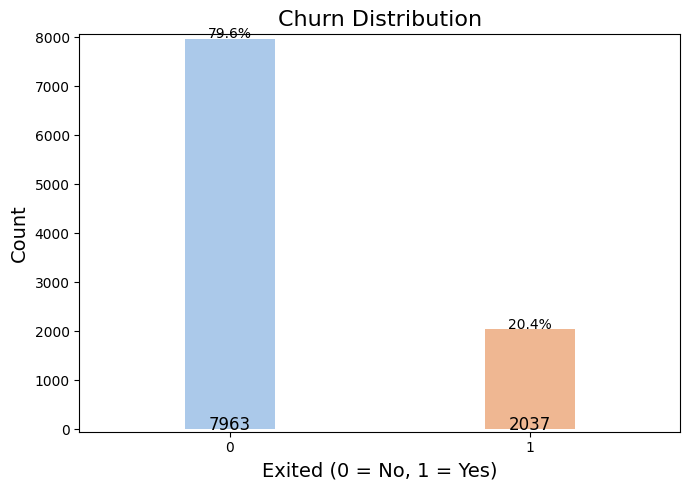

In [8]:
# Cell 7: Exploratory Data Analysis (EDA)

# Churn Rate Analysis
churn_rate = df['Exited'].mean()
print(f"Churn Rate: {churn_rate:.2%}")

# Visualize Churn Rate with Enhanced Presentation
plt.figure(figsize=(7, 5))  # Adjusted figure size for better visibility

# Create a count plot with a color palette
sns.countplot(x='Exited', data=df, palette='pastel', width=0.3)  # Reduced width for bars

# Add title and labels
plt.title('Churn Distribution', fontsize=16)
plt.xlabel('Exited (0 = No, 1 = Yes)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add text annotations for counts at the bottom of the bars
count_values = df['Exited'].value_counts()
for index, value in enumerate(count_values):
    plt.text(index, -10, str(value), ha='center', fontsize=12, color='black')

# Add percentage annotations on top of the bars
for index, value in enumerate(count_values):
    percentage = (value / count_values.sum()) * 100
    plt.text(index, value + 20, f"{percentage:.1f}%", ha='center', fontsize=10, color='black')

# Adjust the y-axis limit for better visibility of annotations
plt.ylim(-50, count_values.max() + 100)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

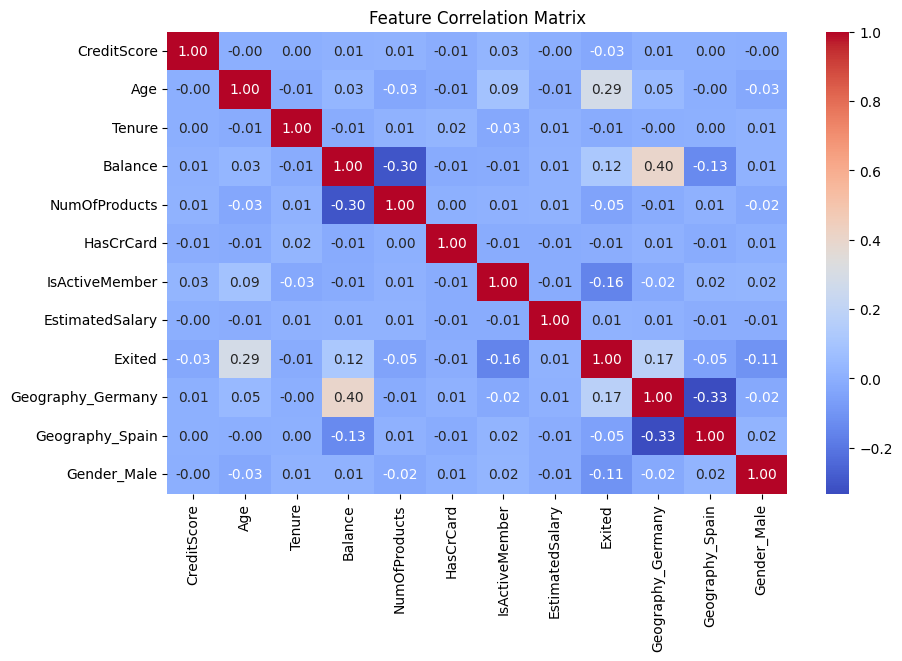

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


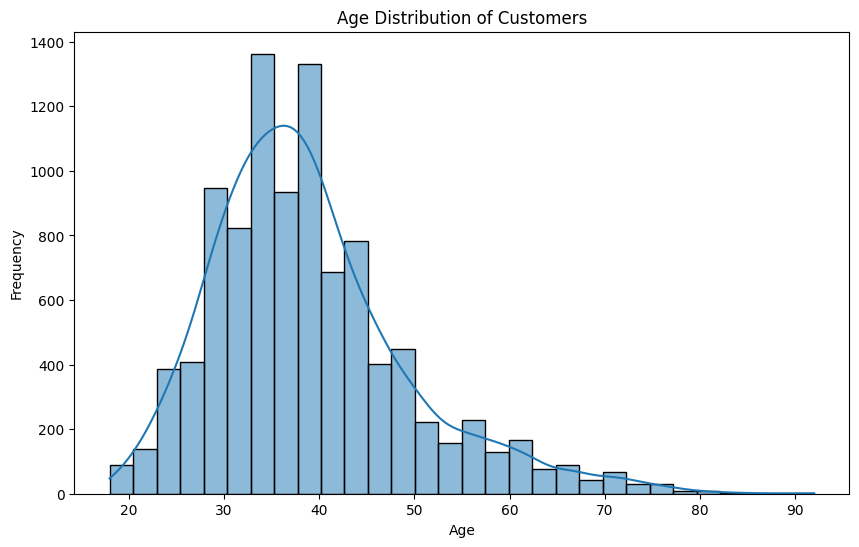

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Feature Engineering

In [11]:
df['AverageBalance'] = df['Balance'] / df['Tenure']

In [12]:
# Replace infinity values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Set a threshold for large values (e.g., 1e10)
threshold = 1e10
df = df.where(df < threshold, np.nan)

# Drop rows with NaN values
df.dropna(inplace=True)

# Verify if there are any remaining NaN values
print("Remaining missing values after cleaning:")
print(df.isnull().sum())

Remaining missing values after cleaning:
CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_Germany    0
Geography_Spain      0
Gender_Male          0
AverageBalance       0
dtype: int64


In [13]:
# Split the Data into Features (X) and Target (y)
X = df.drop('Exited', axis=1)
y = df['Exited']

In [14]:
# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [15]:
# Standardize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

In [18]:
# Perform K-Fold Cross-Validation and Store Results
results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y_resampled, cv=kf, scoring='accuracy')
    results[name] = cv_scores.mean()

C:\Users\nyoja\AppData\Local\Temp\ipykernel_17912\2174868815.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


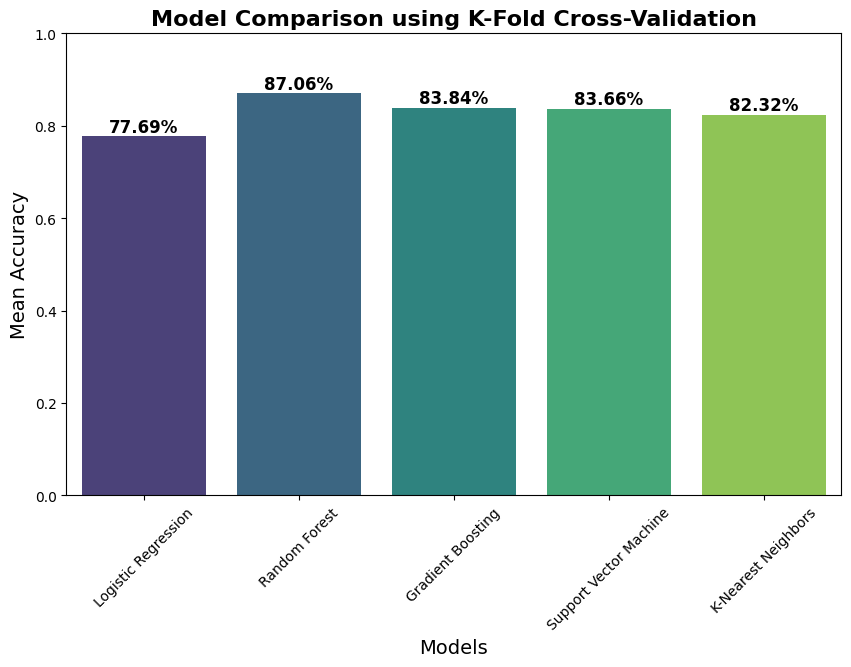

In [19]:
# Cell: Plot Comparison of Model Performance
plt.figure(figsize=(10, 6))

# Create a bar plot with a color palette
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')

# Add title and labels
plt.title('Model Comparison using K-Fold Cross-Validation', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=14)
plt.ylabel('Mean Accuracy', fontsize=14)
plt.ylim(0, 1)

# Add percentage values on top of the bars
for index, value in enumerate(results.values()):
    plt.text(index, value + 0.01, f"{value:.2%}", ha='center', fontsize=12, fontweight='bold')

# Rotate x-tick labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [20]:
# Feature Selection using RFE (Example with Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFE(rf_model, n_features_to_select=5)
selector = selector.fit(X_scaled, y_resampled)
print("Selected Features:", X.columns[selector.support_])

Selected Features: Index(['CreditScore', 'Age', 'IsActiveMember', 'EstimatedSalary',
       'AverageBalance'],
      dtype='object')


In [21]:
# Hyperparameter Tuning for Random Forest (Example)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='accuracy')
grid_search.fit(X_scaled, y_resampled)

print("Best parameters for Random Forest:", grid_search.best_params_)
print("Best cross-validation score for Random Forest:", grid_search.best_score_)

Best parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score for Random Forest: 0.8711576193590582


In [22]:
# Evaluate the Best Model
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_scaled, y_resampled)
y_pred = best_rf_model.predict(X_scaled)

print("Random Forest Classification Report:")
print(classification_report(y_resampled, y_pred))
print("Accuracy:", accuracy_score(y_resampled, y_pred))
print("ROC AUC Score:", roc_auc_score(y_resampled, best_rf_model.predict_proba(X_scaled)[:, 1]))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7645
           1       1.00      1.00      1.00      7645

    accuracy                           1.00     15290
   macro avg       1.00      1.00      1.00     15290
weighted avg       1.00      1.00      1.00     15290

Accuracy: 1.0
ROC AUC Score: 1.0


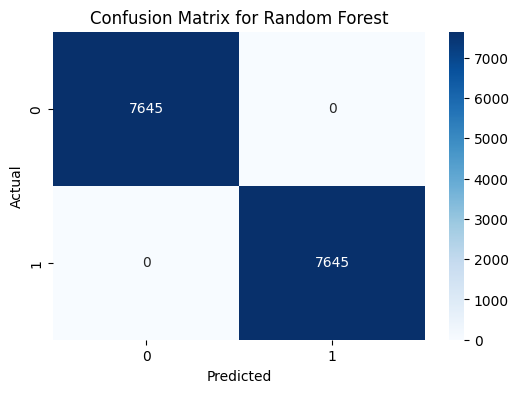

In [23]:
# Confusion Matrix for the Best Model
cm = confusion_matrix(y_resampled, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [24]:
# # Use KernelExplainer as an alternative
# explainer = shap.KernelExplainer(best_rf_model.predict, X_scaled)
# shap_values = explainer.shap_values(X_scaled, nsamples=100)

# # Visualize SHAP values
# shap.summary_plot(shap_values, X, feature_names=X.columns)


In [25]:
# Verify feature names in X
feature_names = X.columns
print(feature_names)


Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male', 'AverageBalance'],
      dtype='object')
